<a href="https://colab.research.google.com/github/clonedSemicolon/Crash-Predictor/blob/master/Car_Crash_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.tree import plot_tree

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import folium

In [36]:
import pandas as pd

# people_path = '/home/umd-user/Downloads/people.csv'
# vehicles_path = '/home/umd-user/Downloads/vehicles.csv'
# crashes_path = '/home/umd-user/Downloads/crashes.csv'

people_path = '/content/drive/MyDrive/people.csv'
vehicles_path = '/content/drive/MyDrive/vehicles.csv'
crashes_path = '/content/drive/MyDrive/crashes.csv'

try:
  people = pd.read_csv(people_path)
  vehicles = pd.read_csv(vehicles_path)
  crashes = pd.read_csv(crashes_path)
  print("Files read successfully.")
except FileNotFoundError:
  print(f"Error: One or more files not found. Check the file paths.")
except pd.errors.EmptyDataError:
    print(f"Error: One or more files are empty.")
except pd.errors.ParserError:
    print(f"Error: One or more files have parsing errors. Check file format.")
except Exception as e:
  print(f"An unexpected error occurred: {e}")


<ipython-input-36-3e9dd59f5561>:12: DtypeWarning: Columns (19,28) have mixed types. Specify dtype option on import or set low_memory=False.
  people = pd.read_csv(people_path)
<ipython-input-36-3e9dd59f5561>:13: DtypeWarning: Columns (20,39,40,41,43,47,48,49,52,54,57,58,60,70) have mixed types. Specify dtype option on import or set low_memory=False.
  vehicles = pd.read_csv(vehicles_path)


Files read successfully.


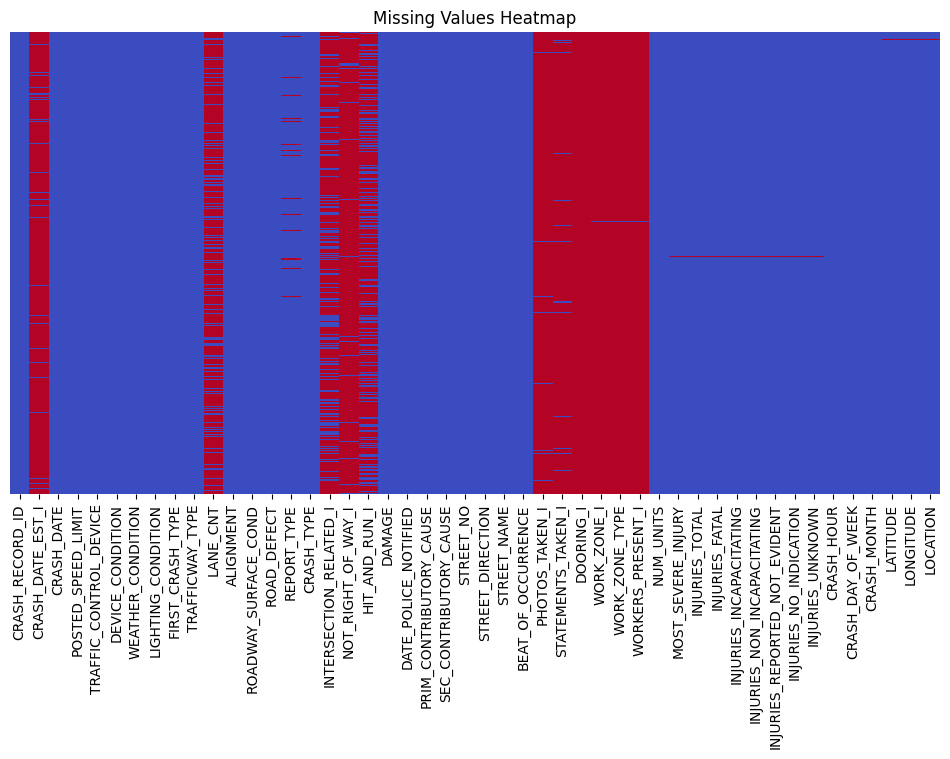

In [5]:
plt.figure(figsize=(12, 6))
sns.heatmap(crashes.isnull(), cmap="coolwarm", cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

In [6]:
#dropping columns either not relevant, or duplicate.
crashes_drop = crashes[['INJURIES_FATAL',
                        'CRASH_DATE_EST_I', 'DATE_POLICE_NOTIFIED',
                        'STREET_NO',
                        'STREET_DIRECTION', 'STREET_NAME',
                        'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I',
                        'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I',
                        'LANE_CNT','REPORT_TYPE','CRASH_TYPE','SEC_CONTRIBUTORY_CAUSE',
                        'INJURIES_INCAPACITATING','INJURIES_NON_INCAPACITATING',
                        'INJURIES_REPORTED_NOT_EVIDENT','INJURIES_NO_INDICATION',
                        'INJURIES_UNKNOWN','MOST_SEVERE_INJURY',
                        'NOT_RIGHT_OF_WAY_I','INTERSECTION_RELATED_I','HIT_AND_RUN_I']]

In [7]:
crashes.drop(columns=crashes_drop, inplace=True)

<ipython-input-8-bb6296c0045e>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  crashes['CRASH_DATE'] = pd.to_datetime(crashes['CRASH_DATE'])  # Ensure datetime format


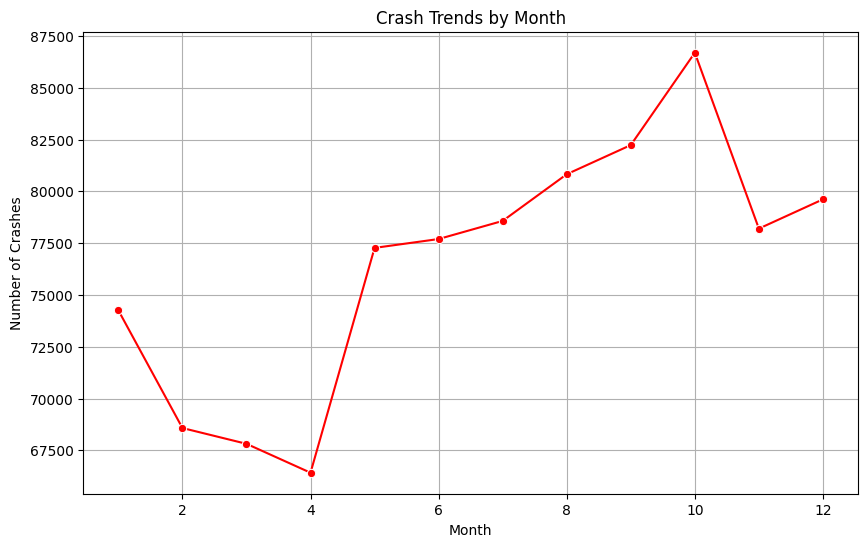

In [8]:
crashes['CRASH_DATE'] = pd.to_datetime(crashes['CRASH_DATE'])  # Ensure datetime format
crashes['CRASH_MONTH'] = crashes['CRASH_DATE'].dt.month
crash_trend = crashes.groupby('CRASH_MONTH').size()

plt.figure(figsize=(10, 6))
sns.lineplot(x=crash_trend.index, y=crash_trend.values, marker="o", color='red')
plt.title("Crash Trends by Month")
plt.xlabel("Month")
plt.ylabel("Number of Crashes")
plt.grid(True)
plt.show()

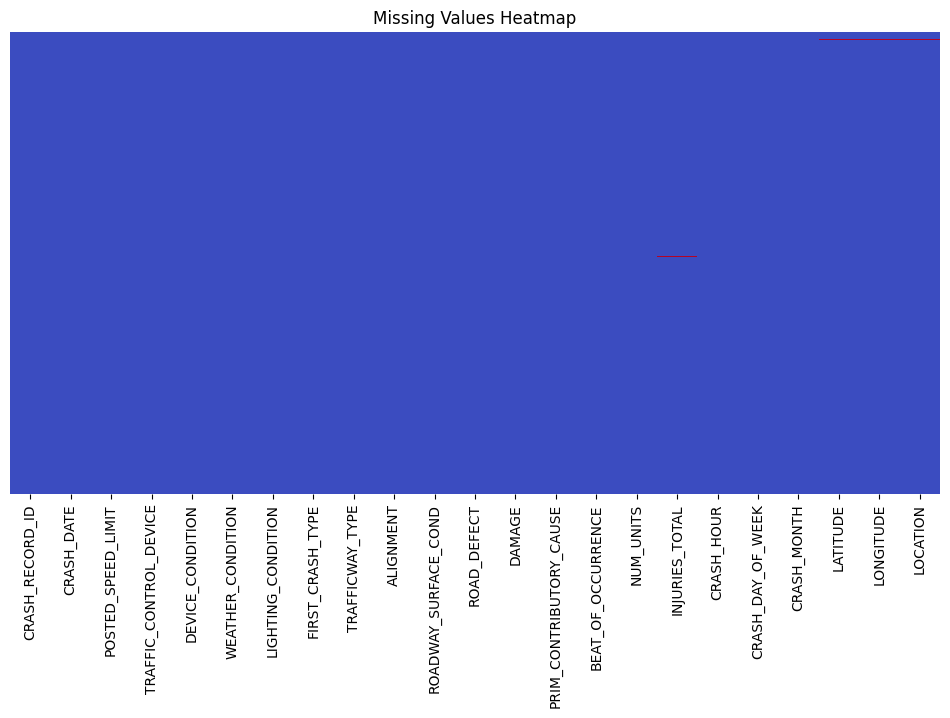

In [9]:
plt.figure(figsize=(12, 6))
sns.heatmap(crashes.isnull(), cmap="coolwarm", cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

In [10]:
def plot_by_day(df, column_name, isWeekDays=False):
    """
    Function to plot the number of crashes by a specified column.

    Parameters:
    df (pd.DataFrame): The dataset containing crash data.
    column_name (str): The column name representing the day (can be numeric or categorical).
    isWeekDays (bool): If True, map numeric days (1-7) to actual day names.

    Returns:
    None (Displays the bar plot)
    """
    # If isWeekDays is True, map numbers to day names
    if isWeekDays:
        day_mapping = {
            1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday',
            5: 'Friday', 6: 'Saturday', 7: 'Sunday'
        }
        df[column_name] = df[column_name].map(day_mapping)

        # Define correct order for days
        ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    else:
        # If isWeekDays is False, use unique values in sorted order
        ordered_days = sorted(df[column_name].unique())

    # Count occurrences
    crash_day_counts = df[column_name].value_counts()

    # Reindex to ensure correct order
    crash_day_counts = crash_day_counts.reindex(ordered_days)

    # Plot bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(x=crash_day_counts.index, y=crash_day_counts.values, palette="coolwarm")

    # Formatting the chart
    plt.title(f"Number of Crashes by {column_name}", fontsize=14)
    plt.xlabel(column_name, fontsize=12)
    plt.ylabel("Number of Crashes", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show plot
    plt.show()



<ipython-input-10-07862896260d>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crash_day_counts.index, y=crash_day_counts.values, palette="coolwarm")


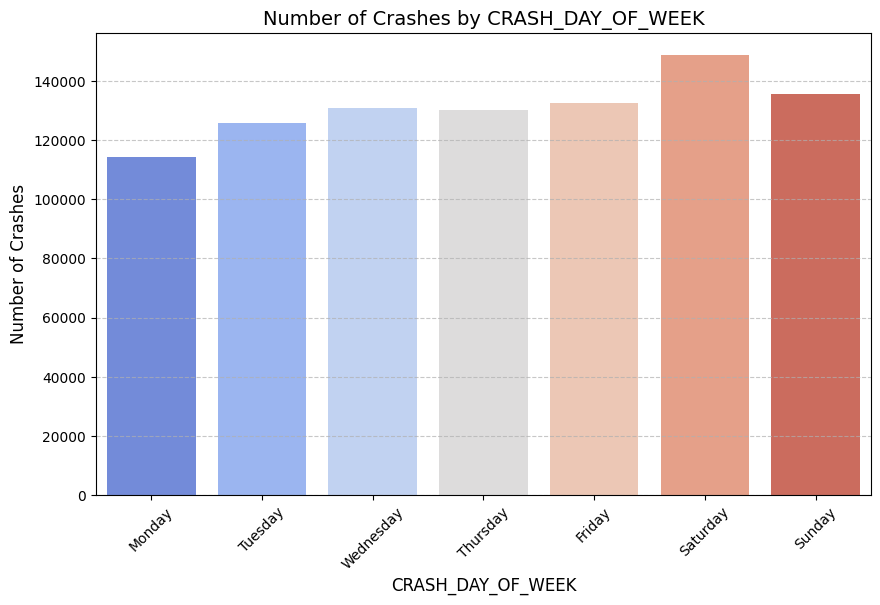

In [11]:
plot_by_day(crashes, 'CRASH_DAY_OF_WEEK',True)

<Axes: xlabel='WEATHER_CONDITION', ylabel='CRASH_MONTH'>

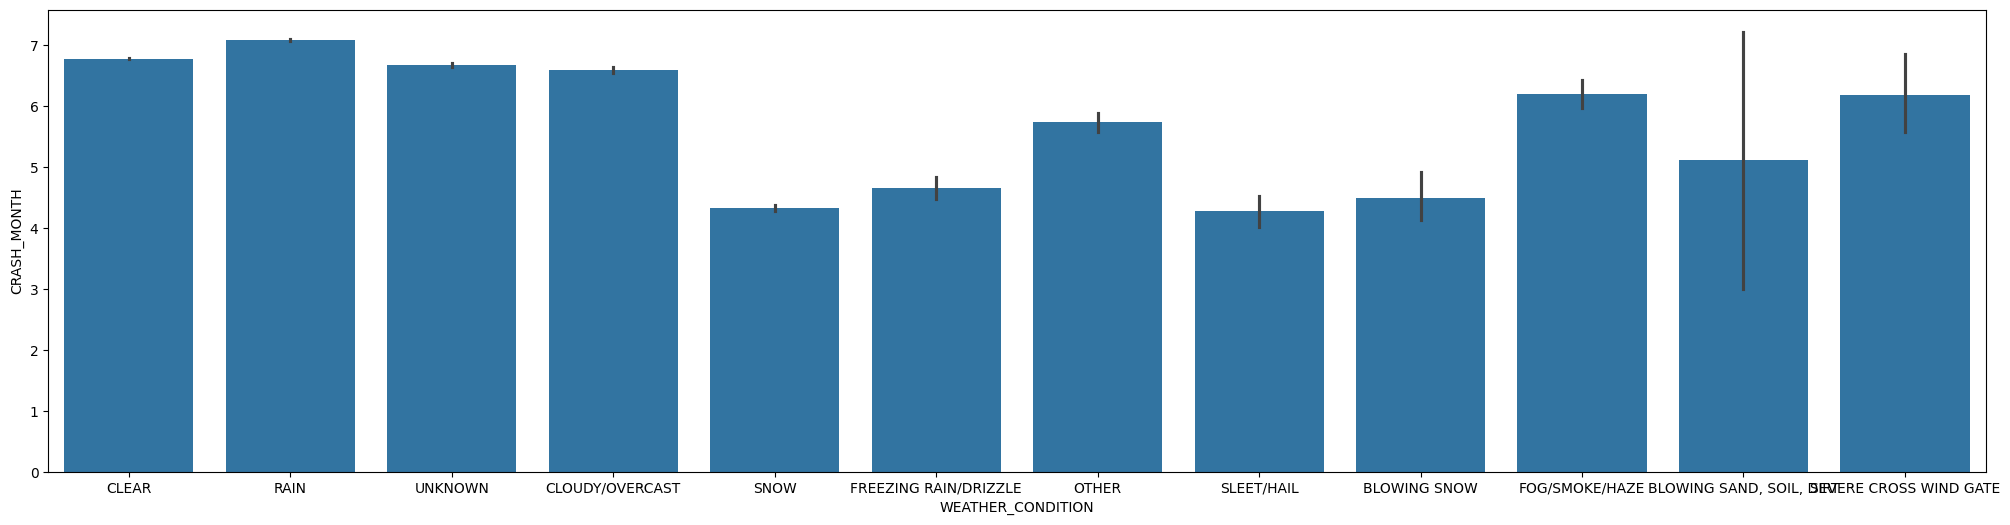

In [12]:
fig, ax = plt.subplots(figsize = (25, 6))
sns.barplot(data = crashes, x = "WEATHER_CONDITION", y= "CRASH_MONTH")

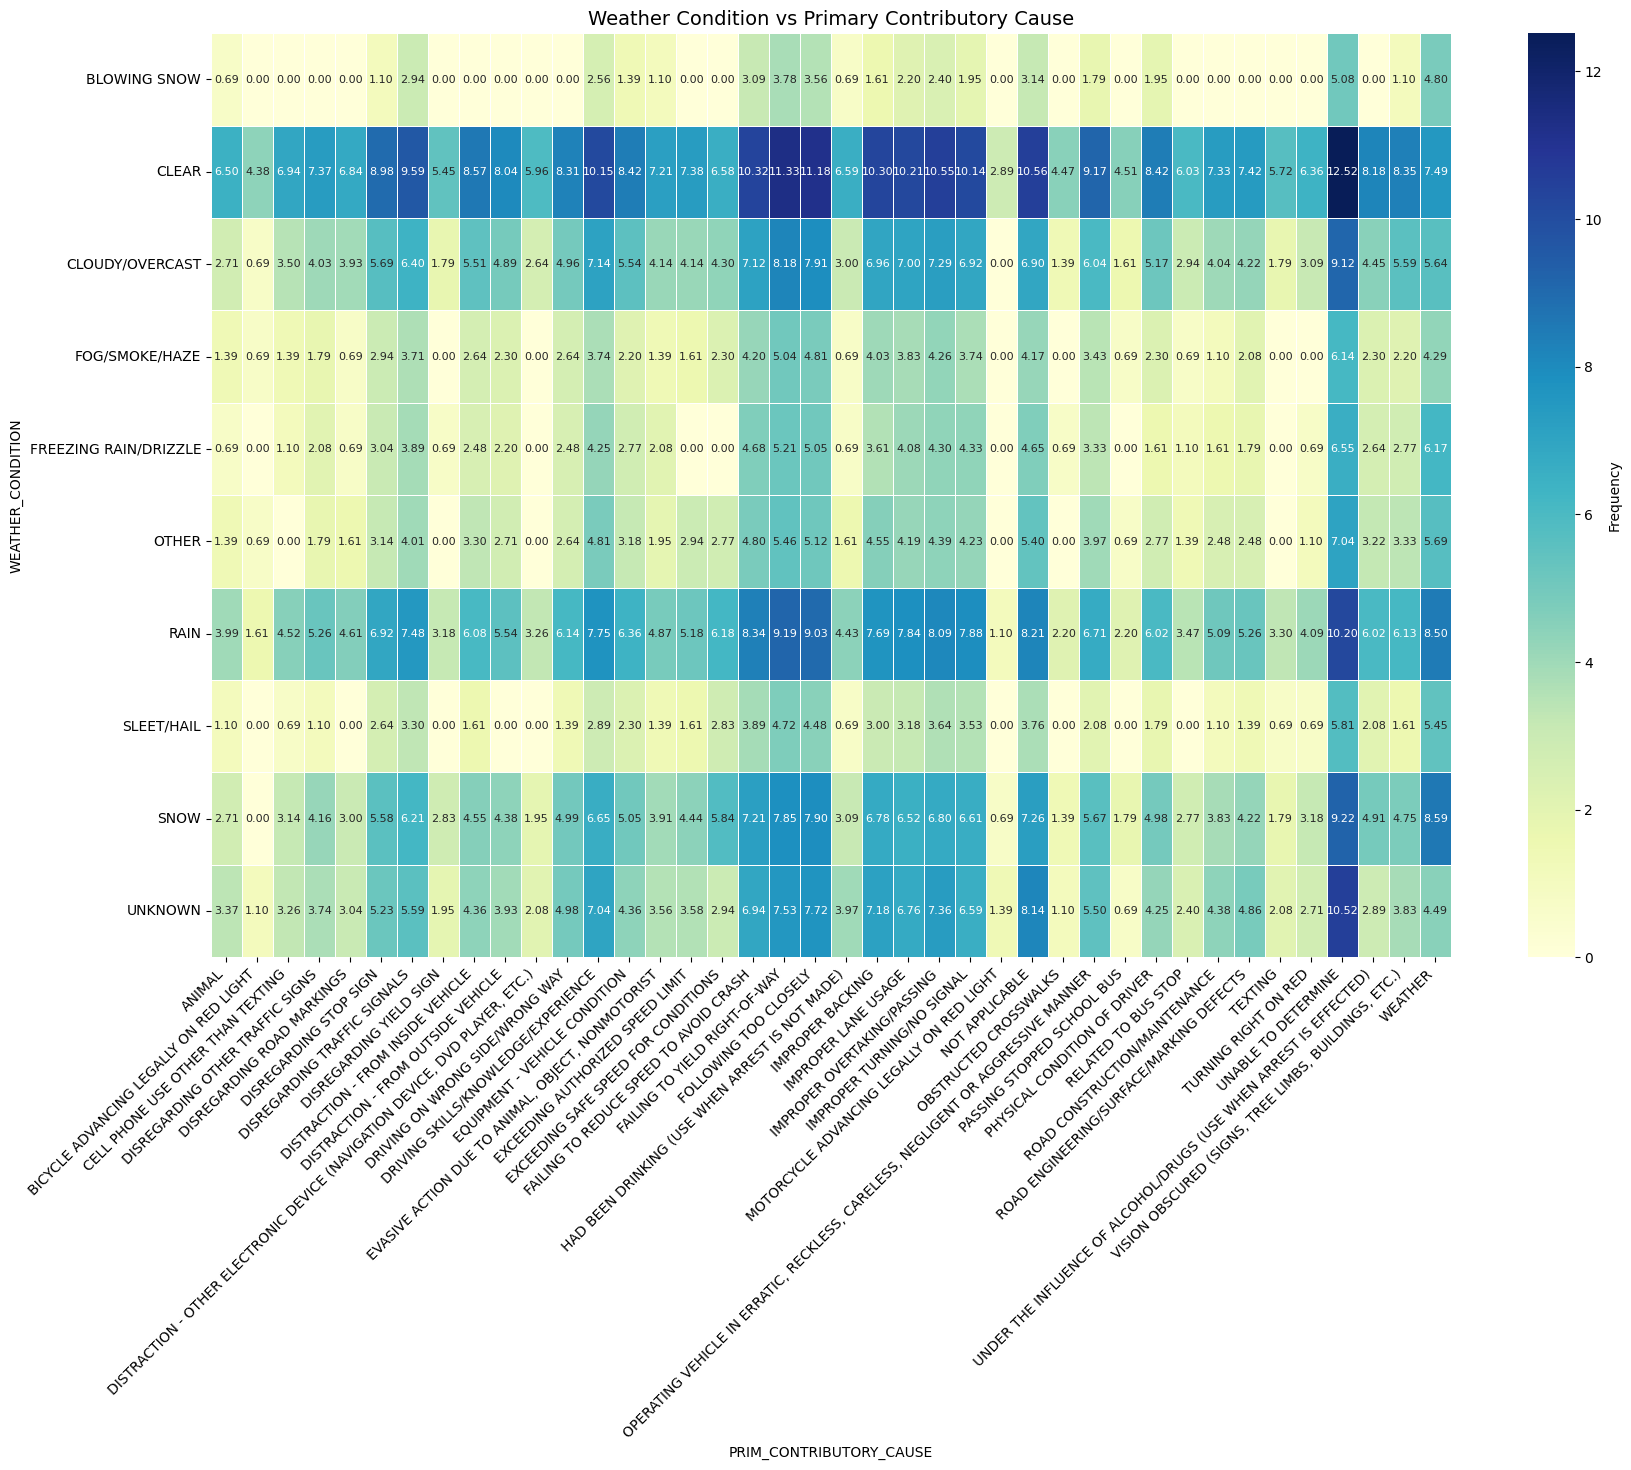

In [13]:
import numpy as np

# Get the top 10 most frequent Weather Conditions
top_weather = crashes['WEATHER_CONDITION'].value_counts().nlargest(10).index

# Filter the dataset to include only the most common weather conditions
filtered_data = crashes[crashes['WEATHER_CONDITION'].isin(top_weather)]

# Create crosstab with filtered data
heatmap_data = pd.crosstab(filtered_data['WEATHER_CONDITION'], filtered_data['PRIM_CONTRIBUTORY_CAUSE']).astype(float)
heatmap_data = np.log1p(heatmap_data)

# Set figure size for better readability
plt.figure(figsize=(20, 12))  # Moderate size

# Generate heatmap
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    linewidths=0.5,
    annot_kws={"size": 8},  # Reduce font size
    cbar_kws={'label': 'Frequency'}
)

# Rotate labels for better readability
plt.xticks(rotation=45, ha="right", fontsize=10)  # Reduce fontsize
plt.yticks(fontsize=10)

# Add a title
plt.title("Weather Condition vs Primary Contributory Cause", fontsize=14)

plt.show()

<ipython-input-14-05b28a682120>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_crashes['CRASH_HOUR'] = filtered_crashes['CRASH_HOUR'].apply(format_hour)


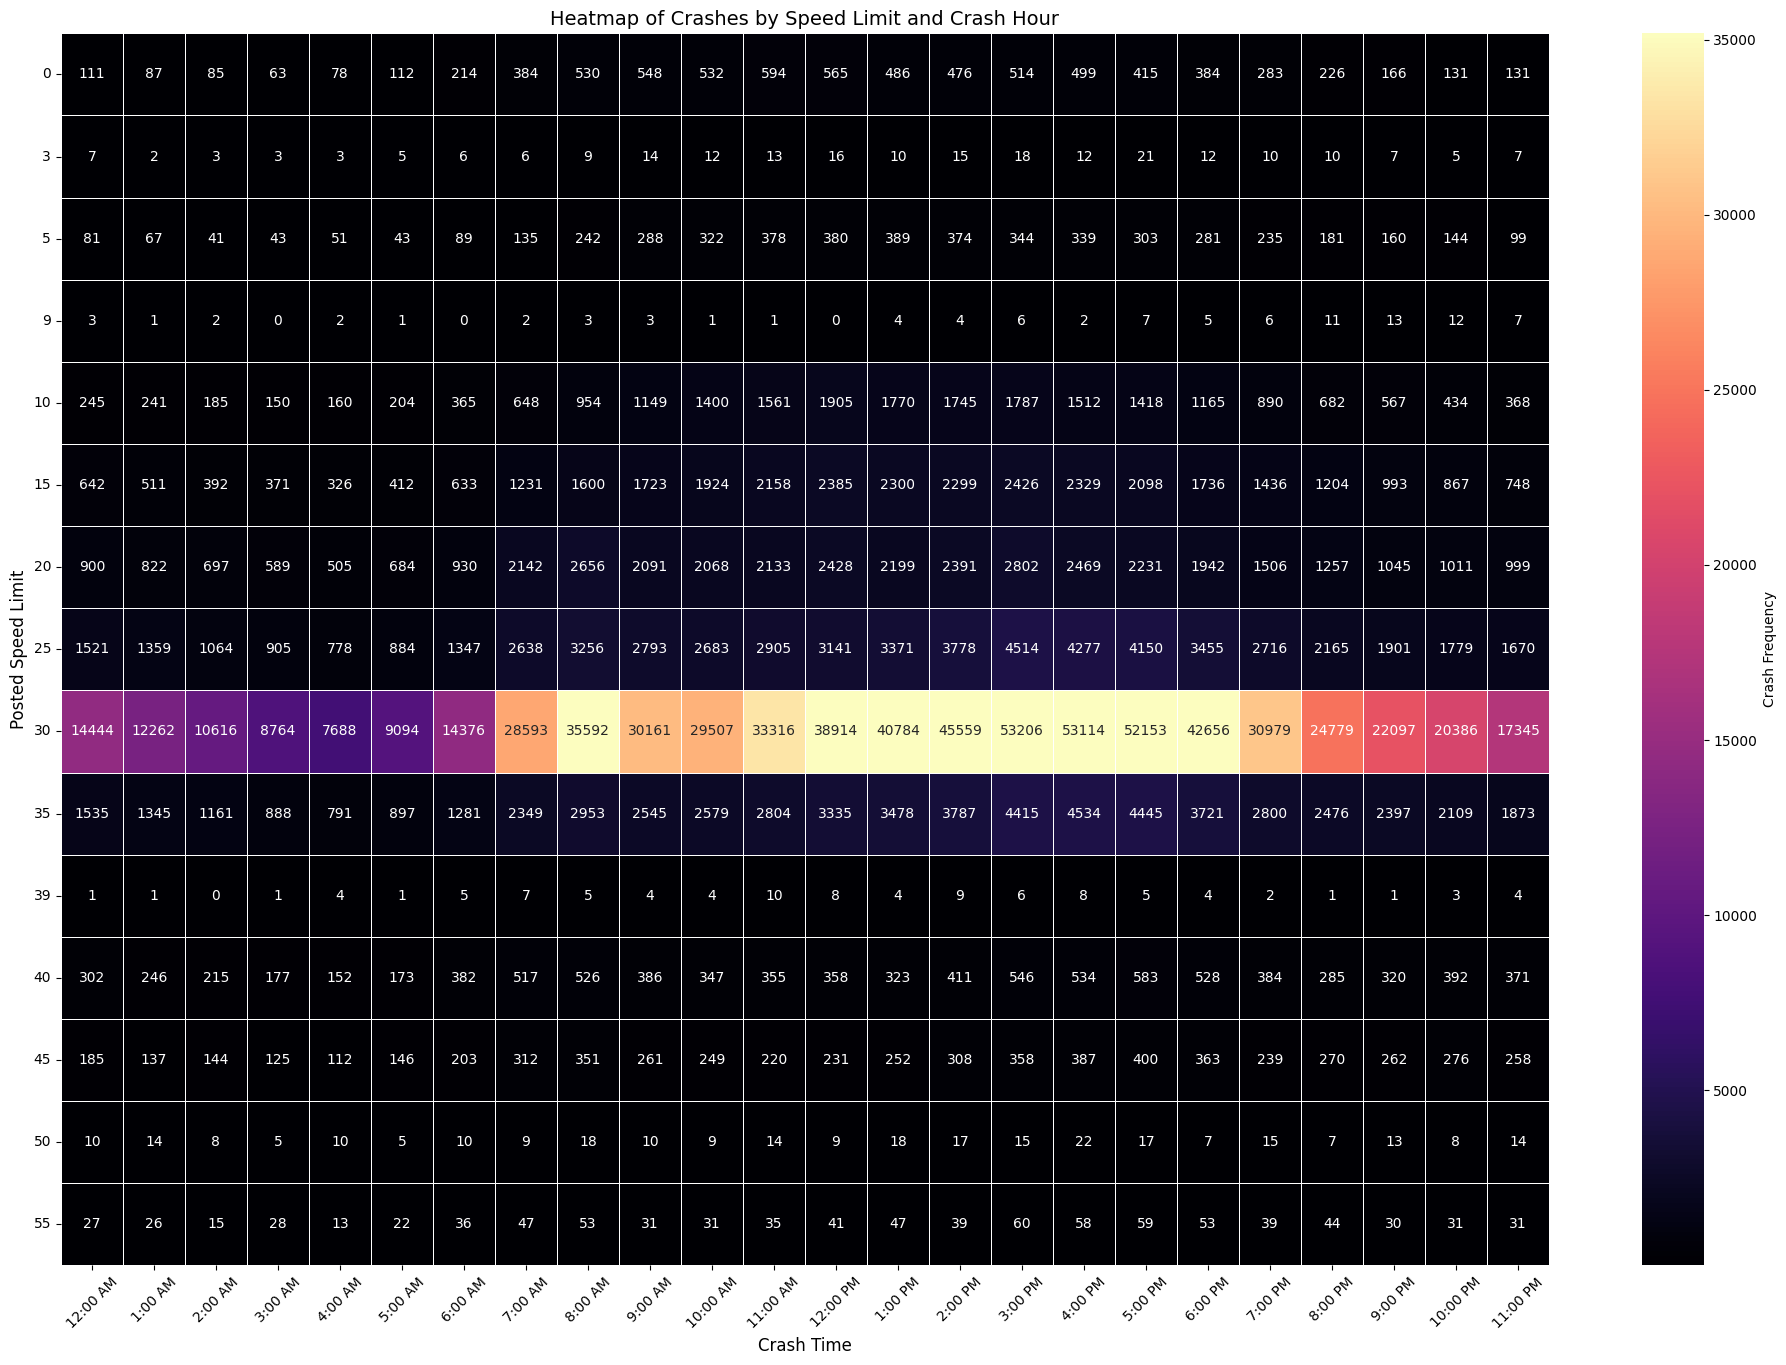

In [14]:
# Step 1: Get the Top 15 Most Frequent Speed Limits
top_speed_limits = crashes['POSTED_SPEED_LIMIT'].value_counts().nlargest(15).index

# Step 2: Get the Top 15 Most Frequent Crash Hours
top_crash_hours = crashes['CRASH_HOUR'].value_counts().nlargest(24).index

# Step 3: Filter the dataset
filtered_crashes = crashes[crashes['POSTED_SPEED_LIMIT'].isin(top_speed_limits) &
                           crashes['CRASH_HOUR'].isin(top_crash_hours)]

# Step 4: Convert Crash Hour to Time Format
def format_hour(hour):
    return f"{hour % 12 or 12}:00 {'AM' if hour < 12 else 'PM'}"

filtered_crashes['CRASH_HOUR'] = filtered_crashes['CRASH_HOUR'].apply(format_hour)

# Step 5: Create the Pivot Table
heatmap_data = filtered_crashes.pivot_table(index="POSTED_SPEED_LIMIT",
                                            columns="CRASH_HOUR",
                                            aggfunc="size",
                                            fill_value=0)

# Step 6: Reorder Hours Chronologically
ordered_hours = [format_hour(h) for h in sorted(top_crash_hours)]
heatmap_data = heatmap_data[ordered_hours]  # Reorder columns

# Step 7: Plot the Heatmap with Better Colors
plt.figure(figsize=(24, 16))
sns.heatmap(heatmap_data, cmap="magma", linewidths=0.5, robust=True, annot=True, fmt="d", cbar_kws={'label': 'Crash Frequency'})

# Formatting
plt.title("Heatmap of Crashes by Speed Limit and Crash Hour", fontsize=14)
plt.xlabel("Crash Time", fontsize=12)
plt.ylabel("Posted Speed Limit", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Show plot
plt.show()


# Analyzing the Vehicle Dataset

In [15]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1872703 entries, 0 to 1872702
Data columns (total 71 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   CRASH_UNIT_ID             int64  
 1   CRASH_RECORD_ID           object 
 2   CRASH_DATE                object 
 3   UNIT_NO                   int64  
 4   UNIT_TYPE                 object 
 5   NUM_PASSENGERS            float64
 6   VEHICLE_ID                float64
 7   CMRC_VEH_I                object 
 8   MAKE                      object 
 9   MODEL                     object 
 10  LIC_PLATE_STATE           object 
 11  VEHICLE_YEAR              float64
 12  VEHICLE_DEFECT            object 
 13  VEHICLE_TYPE              object 
 14  VEHICLE_USE               object 
 15  TRAVEL_DIRECTION          object 
 16  MANEUVER                  object 
 17  TOWED_I                   object 
 18  FIRE_I                    object 
 19  OCCUPANT_CNT              float64
 20  EXCEED_SPEED_LIMIT_I    

In [16]:
# Define the mapping for better visualization
vehicle_mapping = {
    "PASSENGER": "Passenger",
    "SPORT UTILITY VEHICLE (SUV)": "SUV",
    "VAN/MINI-VAN": "Van",
    "PICKUP": "Pickup",
    "UNKNOWN/NA": "Unknown",
    "TRUCK - SINGLE UNIT": "Truck",
    "TRACTOR W/ SEMI-TRAILER": "Semi-Truck",
    "TRACTOR W/O SEMI-TRAILER": "Truck",
    "SINGLE UNIT TRUCK WITH TRAILER": "Truck",
    "OTHER VEHICLE WITH TRAILER": "Other",
    "BUS OVER 15 PASS.": "Bus",
    "BUS UP TO 15 PASS.": "Bus",
    "MOTORCYCLE (OVER 150CC)": "Motorcycle",
    "AUTOCYCLE": "Motorcycle",
    "MOPED OR MOTORIZED BICYCLE": "Moped",
    "MOTOR DRIVEN CYCLE": "Moped",
    "ALL-TERRAIN VEHICLE (ATV)": "ATV",
    "SNOWMOBILE": "ATV",
    "3-WHEELED MOTORCYCLE (2 REAR WHEELS)": "Motorcycle",
    "FARM EQUIPMENT": "Other",
    "RECREATIONAL OFF-HIGHWAY VEHICLE (ROV)": "Other",
    "OTHER": "Other"
}

# Apply the mapping
vehicles["VEHICLE_TYPE_CLEAN"] = vehicles["VEHICLE_TYPE"].map(vehicle_mapping).fillna("Unknown")


<ipython-input-17-b212ed6d54f1>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(y=vehicle_counts.index, x=vehicle_counts.values, palette=colors)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


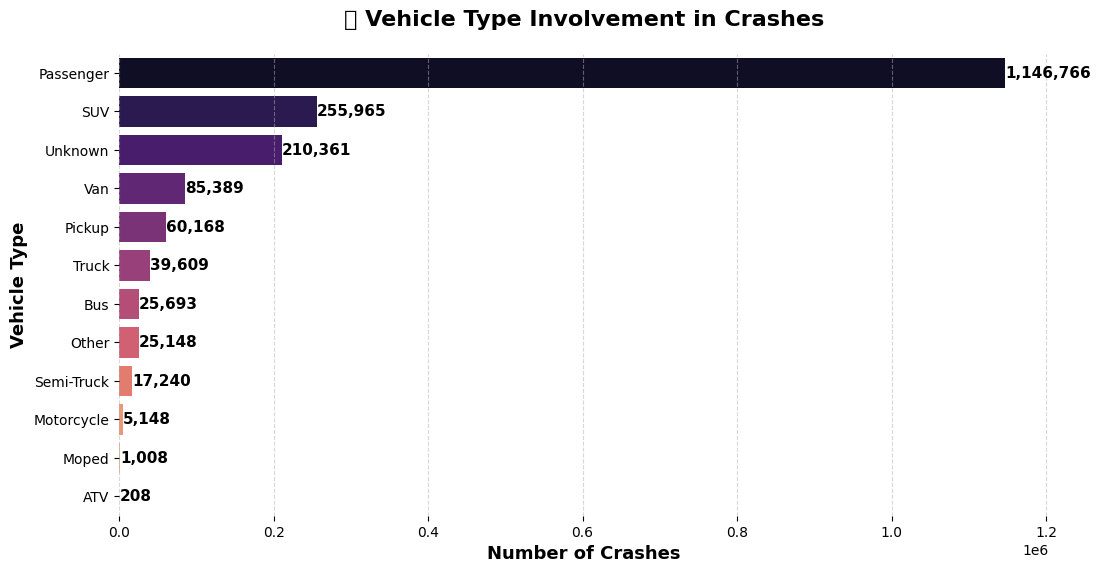

In [17]:
# Count crashes per vehicle type
vehicle_counts = vehicles["VEHICLE_TYPE_CLEAN"].value_counts()

# Define color gradient based on crash frequency
colors = sns.color_palette("magma", len(vehicle_counts))

# Create figure and axis
plt.figure(figsize=(12, 6))
bars = sns.barplot(y=vehicle_counts.index, x=vehicle_counts.values, palette=colors)

# Add value labels to the bars
for bar, count in zip(bars.patches, vehicle_counts.values):
    plt.text(bar.get_width() + 50,  # Adjust position
             bar.get_y() + bar.get_height()/2,
             f"{count:,}",  # Format numbers with commas
             ha='left', va='center', fontsize=11, fontweight='bold', color='black')

# Styling and layout
plt.title("🚗 Vehicle Type Involvement in Crashes", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Number of Crashes", fontsize=13, fontweight='bold')
plt.ylabel("Vehicle Type", fontsize=13, fontweight='bold')
plt.grid(axis="x", linestyle="--", alpha=0.5)

# Remove unnecessary spines for a cleaner look
sns.despine(left=True, bottom=True)

# Show plot
plt.show()

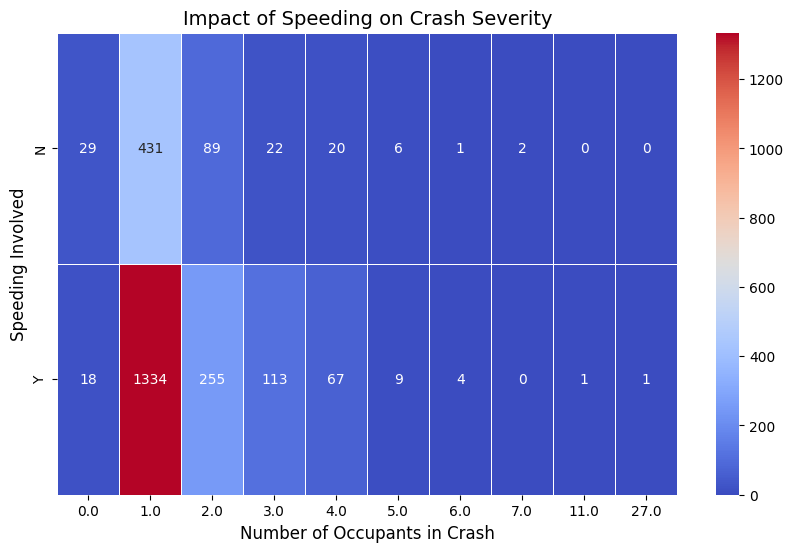

In [18]:
speed_severity = vehicles.pivot_table(index="EXCEED_SPEED_LIMIT_I",
                                     columns="OCCUPANT_CNT",
                                     aggfunc="size",
                                     fill_value=0)

plt.figure(figsize=(10, 6))
sns.heatmap(speed_severity, cmap="coolwarm", annot=True, fmt="d", linewidths=0.5)

plt.title("Impact of Speeding on Crash Severity", fontsize=14)
plt.xlabel("Number of Occupants in Crash", fontsize=12)
plt.ylabel("Speeding Involved", fontsize=12)
plt.show()

In [19]:
people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2015929 entries, 0 to 2015928
Data columns (total 29 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   PERSON_ID              object 
 1   PERSON_TYPE            object 
 2   CRASH_RECORD_ID        object 
 3   VEHICLE_ID             float64
 4   CRASH_DATE             object 
 5   SEAT_NO                float64
 6   CITY                   object 
 7   STATE                  object 
 8   ZIPCODE                object 
 9   SEX                    object 
 10  AGE                    float64
 11  DRIVERS_LICENSE_STATE  object 
 12  DRIVERS_LICENSE_CLASS  object 
 13  SAFETY_EQUIPMENT       object 
 14  AIRBAG_DEPLOYED        object 
 15  EJECTION               object 
 16  INJURY_CLASSIFICATION  object 
 17  HOSPITAL               object 
 18  EMS_AGENCY             object 
 19  EMS_RUN_NO             object 
 20  DRIVER_ACTION          object 
 21  DRIVER_VISION          object 
 22  PHYSICAL_CONDITION

In [37]:
people_drop = people[['PERSON_ID', 'CRASH_DATE', 'CITY', 'STATE', 'ZIPCODE', 'DRIVERS_LICENSE_STATE',
                      'HOSPITAL',  'EMS_RUN_NO',
                      'DRIVER_ACTION', 'PHYSICAL_CONDITION', 'PEDPEDAL_ACTION','EJECTION',
                      'PEDPEDAL_VISIBILITY', 'PEDPEDAL_LOCATION',
                      ]]
people.drop(columns=people_drop, inplace=True)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128274 (\N{LOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


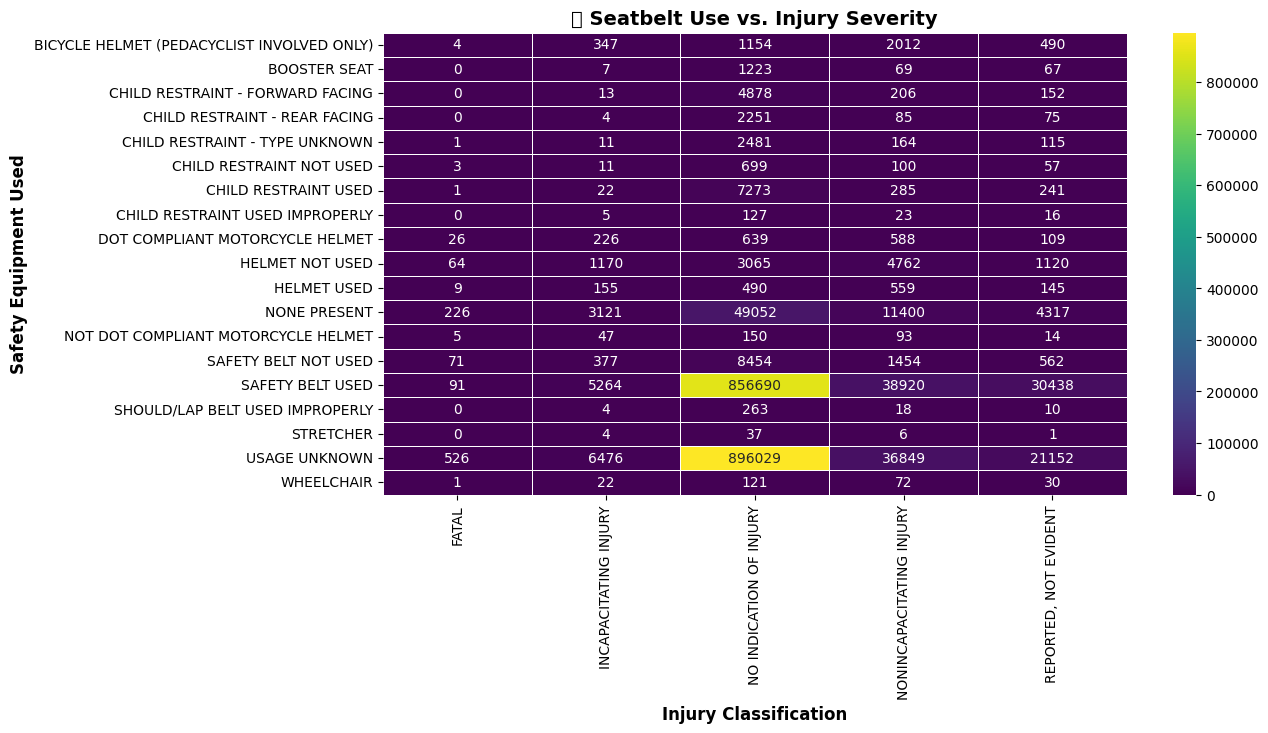

In [38]:
# Create a pivot table
seatbelt_injury = people.pivot_table(index="SAFETY_EQUIPMENT", columns="INJURY_CLASSIFICATION", aggfunc="size", fill_value=0)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(seatbelt_injury, cmap="viridis", annot=True, fmt="d", linewidths=0.5)

# Formatting
plt.title("🔒 Seatbelt Use vs. Injury Severity", fontsize=14, fontweight='bold')
plt.xlabel("Injury Classification", fontsize=12, fontweight='bold')
plt.ylabel("Safety Equipment Used", fontsize=12, fontweight='bold')

plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127866 (\N{BEER MUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


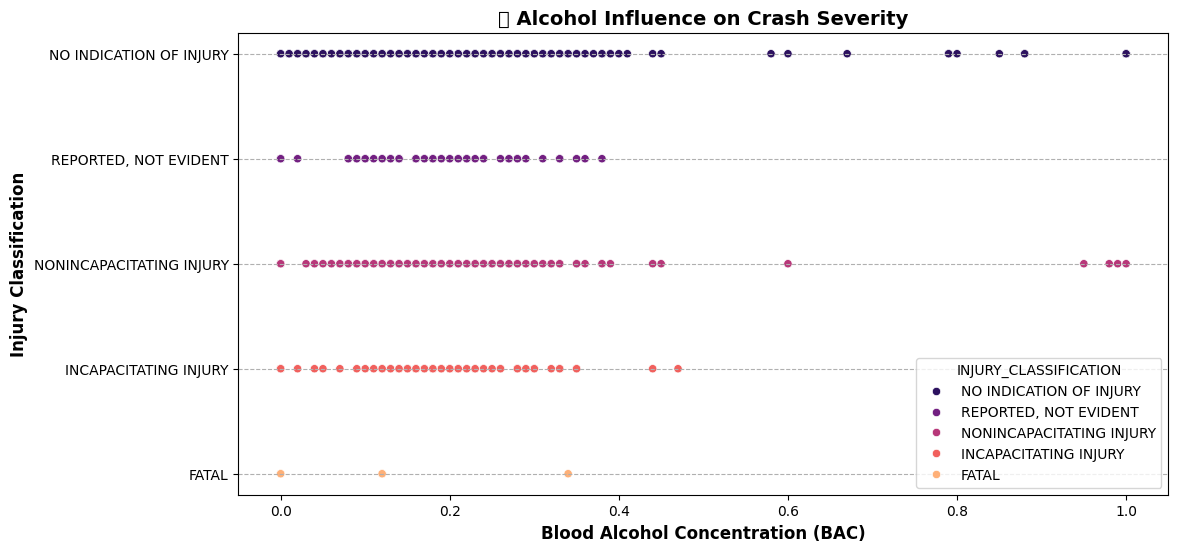

In [39]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=people["BAC_RESULT VALUE"], y=people["INJURY_CLASSIFICATION"], hue=people["INJURY_CLASSIFICATION"], palette="magma")

# Formatting
plt.title("🍺 Alcohol Influence on Crash Severity", fontsize=14, fontweight='bold')
plt.xlabel("Blood Alcohol Concentration (BAC)", fontsize=12, fontweight='bold')
plt.ylabel("Injury Classification", fontsize=12, fontweight='bold')
plt.grid(axis='y', linestyle='--')

plt.show()


<ipython-input-40-c6e39f06a711>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=people["CELL_PHONE_USE"].value_counts().index, x=people["CELL_PHONE_USE"].value_counts().values, palette="coolwarm")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128241 (\N{MOBILE PHONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


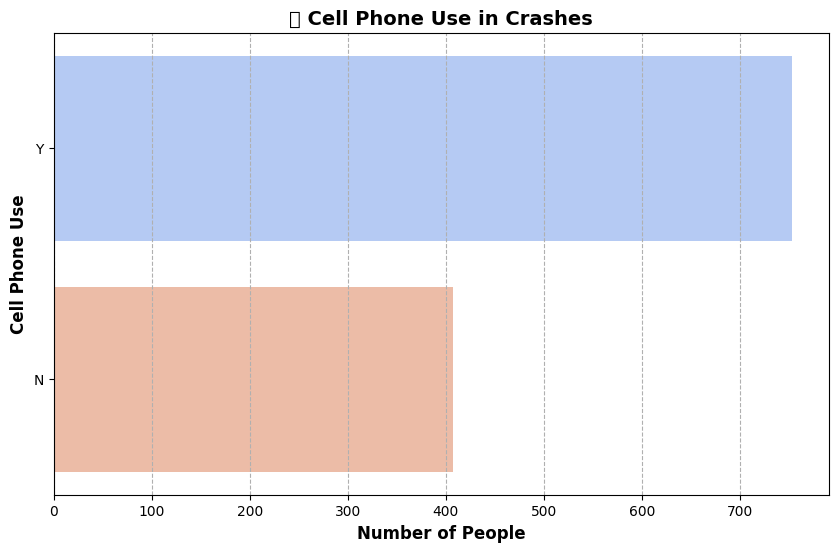

In [40]:
plt.figure(figsize=(10, 6))
sns.barplot(y=people["CELL_PHONE_USE"].value_counts().index, x=people["CELL_PHONE_USE"].value_counts().values, palette="coolwarm")

# Formatting
plt.title("📱 Cell Phone Use in Crashes", fontsize=14, fontweight='bold')
plt.xlabel("Number of People", fontsize=12, fontweight='bold')
plt.ylabel("Cell Phone Use", fontsize=12, fontweight='bold')
plt.grid(axis="x", linestyle="--")

plt.show()

<Axes: xlabel='AGE', ylabel='Count'>

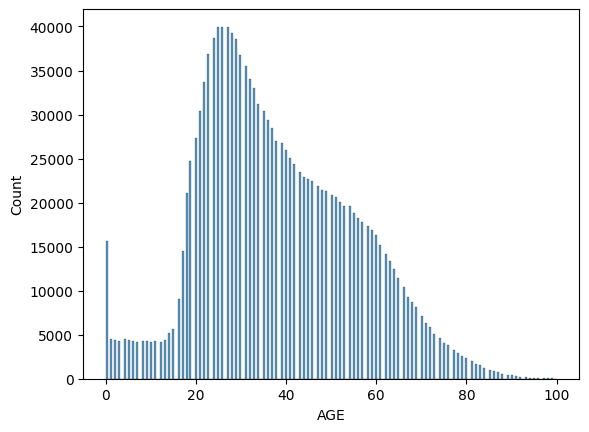

In [41]:
import seaborn as sns
VEHICHLE_YEAR = people['AGE'].value_counts().nlargest(15)
sns.histplot(people['AGE'], binrange=(0, 100))


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


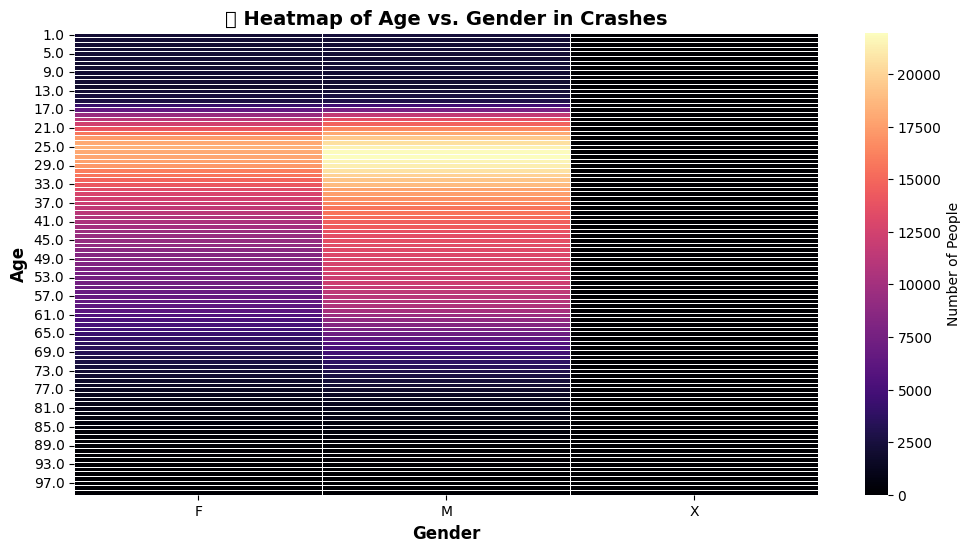

In [42]:
# Ensure 'AGE' is numeric and remove unrealistic values (e.g., negative ages)
people["AGE"] = pd.to_numeric(people["AGE"], errors="coerce")
people = people[(people["AGE"] > 0) & (people["AGE"] < 100)]  # Keeping reasonable ages

# Create a pivot table for the heatmap (counting occurrences)
age_gender_heatmap = people.pivot_table(index="AGE", columns="SEX", aggfunc="size", fill_value=0)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(age_gender_heatmap, cmap="magma", linewidths=0.5, annot=False, cbar_kws={'label': 'Number of People'})

# Formatting
plt.title("👥 Heatmap of Age vs. Gender in Crashes", fontsize=14, fontweight='bold')
plt.xlabel("Gender", fontsize=12, fontweight='bold')
plt.ylabel("Age", fontsize=12, fontweight='bold')
plt.xticks(rotation=0)
plt.yticks(rotation=0)

# Show plot
plt.show()


In [43]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1872703 entries, 0 to 1872702
Data columns (total 71 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   CRASH_UNIT_ID             int64  
 1   CRASH_RECORD_ID           object 
 2   CRASH_DATE                object 
 3   UNIT_NO                   int64  
 4   UNIT_TYPE                 object 
 5   NUM_PASSENGERS            float64
 6   VEHICLE_ID                float64
 7   CMRC_VEH_I                object 
 8   MAKE                      object 
 9   MODEL                     object 
 10  LIC_PLATE_STATE           object 
 11  VEHICLE_YEAR              float64
 12  VEHICLE_DEFECT            object 
 13  VEHICLE_TYPE              object 
 14  VEHICLE_USE               object 
 15  TRAVEL_DIRECTION          object 
 16  MANEUVER                  object 
 17  TOWED_I                   object 
 18  FIRE_I                    object 
 19  OCCUPANT_CNT              float64
 20  EXCEED_SPEED_LIMIT_I    

In [44]:
#dropping columns either not relevant, or duplicate.
vehicles_drop = vehicles[['CRASH_DATE', 'LIC_PLATE_STATE', 'AREA_00_I', 'AREA_01_I','UNIT_NO',
                                       'AREA_02_I', 'AREA_03_I','AREA_04_I','AREA_05_I','AREA_06_I','AREA_07_I',
                                       'AREA_08_I','AREA_09_I','AREA_10_I','AREA_11_I','AREA_12_I','AREA_99_I',
                                       'CMV_ID', 'USDOT_NO', 'CCMC_NO', 'ILCC_NO', 'COMMERCIAL_SRC', 'GVWR',
                                       'CARRIER_NAME', 'CARRIER_CITY', 'HAZMAT_PLACARDS_I','EXCEED_SPEED_LIMIT_I',
                                       'HAZMAT_NAME', 'UN_NO','HAZMAT_PRESENT_I', 'HAZMAT_REPORT_I',
                                       'HAZMAT_REPORT_NO', 'MCS_REPORT_I', 'IDOT_PERMIT_NO',
                                       'WIDE_LOAD_I', 'TRAILER1_WIDTH', 'TRAILER2_WIDTH', 'TRAILER1_LENGTH',
                                       'TRAILER2_LENGTH', 'TOTAL_VEHICLE_LENGTH', 'AXLE_CNT',
                                       'LOAD_TYPE', 'HAZMAT_OUT_OF_SERVICE_I', 'MCS_OUT_OF_SERVICE_I',
                                       'HAZMAT_CLASS', 'MAKE', 'MODEL', 'VEHICLE_YEAR', 'VEHICLE_DEFECT',
                                       'VEHICLE_CONFIG', 'CARGO_BODY_TYPE', 'TOWED_BY',
                                       'TOWED_I', 'CARRIER_STATE',
                                       'FIRE_I', 'MCS_REPORT_NO','HAZMAT_VIO_CAUSE_CRASH_I',
                                       'MCS_VIO_CAUSE_CRASH_I', 'TOWED_TO',
                                       'CMRC_VEH_I','VEHICLE_ID', 'OCCUPANT_CNT', 'NUM_PASSENGERS',
                                       'TRAVEL_DIRECTION', 'MANEUVER',
                                       'VEHICLE_USE', 'CRASH_UNIT_ID']]

In [45]:
vehicles.drop(columns=vehicles_drop, inplace=True)

# Merging the vehicles,crash and people dataset

In [46]:
merge = pd.merge(crashes, vehicles, on='CRASH_RECORD_ID')
df_merge = pd.merge(merge, people, on='CRASH_RECORD_ID')
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2977117 entries, 0 to 2977116
Data columns (total 65 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   CRASH_RECORD_ID                object 
 1   CRASH_DATE_EST_I               object 
 2   CRASH_DATE                     object 
 3   POSTED_SPEED_LIMIT             int64  
 4   TRAFFIC_CONTROL_DEVICE         object 
 5   DEVICE_CONDITION               object 
 6   WEATHER_CONDITION              object 
 7   LIGHTING_CONDITION             object 
 8   FIRST_CRASH_TYPE               object 
 9   TRAFFICWAY_TYPE                object 
 10  LANE_CNT                       float64
 11  ALIGNMENT                      object 
 12  ROADWAY_SURFACE_COND           object 
 13  ROAD_DEFECT                    object 
 14  REPORT_TYPE                    object 
 15  CRASH_TYPE                     object 
 16  INTERSECTION_RELATED_I         object 
 17  NOT_RIGHT_OF_WAY_I             object 
 18  HI

In [47]:
df_merge.head()

,CRASH_RECORD_ID,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,...,AGE,DRIVERS_LICENSE_CLASS,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,INJURY_CLASSIFICATION,EMS_AGENCY,DRIVER_VISION,BAC_RESULT,BAC_RESULT VALUE,CELL_PHONE_USE
0,00a530520c84927490b597a6220ff3f2a3347472ef3086...,NaN,01/15/2025 01:50:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,FIXED OBJECT,RAMP,...,55.0,A,SAFETY BELT USED,NOT APPLICABLE,NO INDICATION OF INJURY,NaN,NOT OBSCURED,TEST NOT OFFERED,NaN,NaN
1,204c3ca48ff3cdf0737e7f10b54ef5f8c49fbe30b5e53e...,NaN,12/04/2024 05:39:00 PM,30,UNKNOWN,UNKNOWN,RAIN,"DARKNESS, LIGHTED ROAD",TURNING,NOT DIVIDED,...,32.0,D,USAGE UNKNOWN,DID NOT DEPLOY,NO INDICATION OF INJURY,NaN,UNKNOWN,TEST NOT OFFERED,NaN,NaN
2,204c3ca48ff3cdf0737e7f10b54ef5f8c49fbe30b5e53e...,NaN,12/04/2024 05:39:00 PM,30,UNKNOWN,UNKNOWN,RAIN,"DARKNESS, LIGHTED ROAD",TURNING,NOT DIVIDED,...,26.0,D,USAGE UNKNOWN,"DEPLOYED, COMBINATION",NO INDICATION OF INJURY,NaN,UNKNOWN,TEST NOT OFFERED,NaN,NaN
3,204c3ca48ff3cdf0737e7f10b54ef5f8c49fbe30b5e53e...,NaN,12/04/2024 05:39:00 PM,30,UNKNOWN,UNKNOWN,RAIN,"DARKNESS, LIGHTED ROAD",TURNING,NOT DIVIDED,...,32.0,D,USAGE UNKNOWN,DID NOT DEPLOY,NO INDICATION OF INJURY,NaN,UNKNOWN,TEST NOT OFFERED,NaN,NaN
4,204c3ca48ff3cdf0737e7f10b54ef5f8c49fbe30b5e53e...,NaN,12/04/2024 05:39:00 PM,30,UNKNOWN,UNKNOWN,RAIN,"DARKNESS, LIGHTED ROAD",TURNING,NOT DIVIDED,...,26.0,D,USAGE UNKNOWN,"DEPLOYED, COMBINATION",NO INDICATION OF INJURY,NaN,UNKNOWN,TEST NOT OFFERED,NaN,NaN


In [1]:
df_merge.hist(figsize=(20,20), bins='auto');

NameError: name 'df_merge' is not defined

In [ ]:
# calculating nulls
nulls = df_merge.isna().sum()
nulls

NameError: name 'df_merge' is not defined

In [ ]:
#Dropping null values
df_merge.fillna(0, inplace=True)

In [ ]:
df_merge.dropna(axis = 1, inplace =True)
df = df_merge.rename(columns=str.lower)
df

In [ ]:
# This columns are not important for our data.
df.drop(['num_units','vehicle_id', 'seat_no',], axis=1, inplace=True)

In [ ]:
df.info()

In [ ]:
#Then examine:
print(df.shape)
df.info()

### **Grouping categorical data into categories, combining similar categories, also replacing missing values. This is useful for reducing the number of unique values in a categorical column, making it easier to analyze.**

### Weather Condition

In [ ]:
df['weather_condition'] = df['weather_condition'].replace({'UNKNOWN':'UNKNOWN/OTHER','OTHER':'UNKNOWN/OTHER',
                                                     'FREEZING RAIN/DRIZZLE': 'SLEET/HAIL',
                                                     'BLOWING SNOW': 'SNOW',
                                                      'SEVERE CROSS WIND GATE': 'CLOUDY/OVERCAST',
                                                     'BLOWING SAND, SOIL, DIRT': 'UNKNOWN/OTHER'})
df['weather_condition'].value_counts()

### Prim Contributory cause

In [ ]:
df.prim_contributory_cause.value_counts()